In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
# === Load both datasets ===
dfs_parallel = {i: pd.read_csv(f"halpha results/NB{i}_halpha_results.csv") for i in [1,2,3,6]}

In [14]:
colors = plt.cm.tab10.colors  # 10 distinct colors
color_map = {i: colors[i-1] for i in range(1, 8)}

In [16]:
center_pixels = {
    1: 190,
    2: 191,
    3: 192,
    6: 190,}

# Combine all lengths into one list
all_lengths = [
    2.069913304, 4.217194803, 1.96915261, 3.266140464, 1.859520678, 3.899131707, 2.481995787,
    13.26115798, 7.801902515, 5.863607675, 5.392712855, 8.840541595, 5.72536702, 6.06715746
]

median_bar_length = np.median(all_lengths)
nb_bar_lengths = {i: median_bar_length for i in center_pixels.keys()}
print(median_bar_length)

4.8049538290000005


In [17]:
def weighted_mean(values, errors, mask):
    vals  = values[mask]
    errs  = errors[mask]
    if np.any(mask) and np.all(errs > 0):
        weights = 1 / errs**2
        mean = np.sum(weights * vals) / np.sum(weights)
        mean_err = np.sqrt(1 / np.sum(weights))
        return mean, mean_err
    return np.nan, np.nan


In [8]:
def summarize_regions(dfs, center_pixels, bar_lengths, take_abs_velocity=True):
    rows = []
    for i, df in dfs.items():
        if i not in center_pixels or i not in bar_lengths:
            continue
        x_rel = (df["center"] - center_pixels[i]) * 0.4  # arcsec
        x_scaled = x_rel / bar_lengths[i]
        abs_x = np.abs(x_scaled)

        center_mask = (abs_x < 0.3)
        bar_mask    = (abs_x >= 0.3) & (abs_x < 0.8)
        out_mask    = (abs_x >= 0.8) & (abs_x <= 1.5)

        vel = np.abs(df["velocity"]) if take_abs_velocity else df["velocity"]

        v_c, v_c_err = weighted_mean(vel, df["velocity_err"], center_mask)
        v_b, v_b_err = weighted_mean(vel, df["velocity_err"], bar_mask)
        v_o, v_o_err = weighted_mean(vel, df["velocity_err"], out_mask)

        s_c, s_c_err = weighted_mean(df["dispersion"], df["dispersion_err"], center_mask)
        s_b, s_b_err = weighted_mean(df["dispersion"], df["dispersion_err"], bar_mask)
        s_o, s_o_err = weighted_mean(df["dispersion"], df["dispersion_err"], out_mask)

        ew_c, ew_c_err = weighted_mean(df["EW"], df["EW_err"], center_mask)
        ew_b, ew_b_err = weighted_mean(df["EW"], df["EW_err"], bar_mask)
        ew_o, ew_o_err = weighted_mean(df["EW"], df["EW_err"], out_mask)

        rows.append({
            "WB": i,
            "v_center": v_c, "v_center_err": v_c_err,
            "v_bar":    v_b, "v_bar_err":    v_b_err,
            "v_out":    v_o, "v_out_err":    v_o_err,
            "σ_center": s_c, "σ_center_err": s_c_err,
            "σ_bar":    s_b, "σ_bar_err":    s_b_err,
            "σ_out":    s_o, "σ_out_err":    s_o_err,
            "EW_center": ew_c, "EW_center_err": ew_c_err,
            "EW_bar":    ew_b, "EW_bar_err":    ew_b_err,
            "EW_out":    ew_o, "EW_out_err":    ew_o_err,
        })
    return pd.DataFrame(rows)


In [20]:
summary_parallel = summarize_regions(dfs_parallel, center_pixels, nb_bar_lengths)

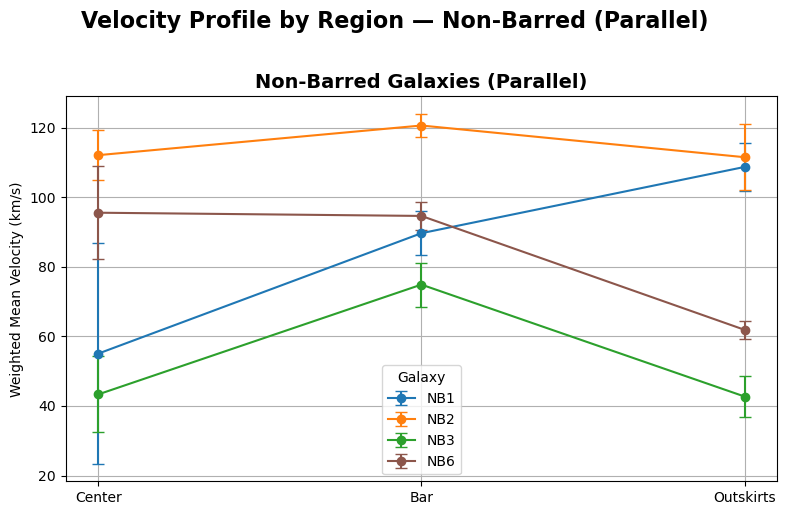

In [24]:
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(8, 5))

for _, row in summary_parallel.iterrows():
    nb_id = int(row["WB"])
    vals = [row["v_center"], row["v_bar"], row["v_out"]]
    errs = [row["v_center_err"], row["v_bar_err"], row["v_out_err"]]
    ax.errorbar(x_pos, vals, yerr=errs, marker='o', capsize=4,
                label=f"NB{nb_id}", color=color_map[nb_id])

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Weighted Mean Velocity (km/s)")
ax.set_title("Non-Barred Galaxies (Parallel)", fontsize=14, fontweight="bold")
ax.grid(True)
ax.legend(title="Galaxy")

fig.suptitle("Velocity Profile by Region — Non-Barred (Parallel)", fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()


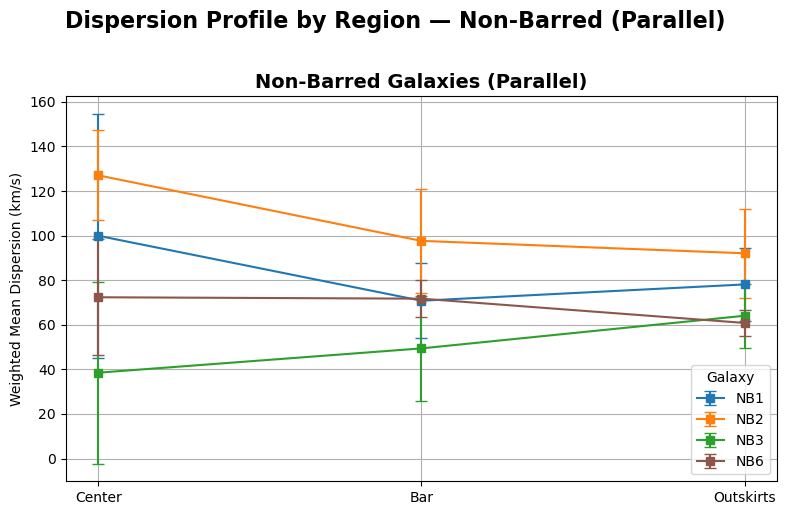

In [25]:
x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(8, 5))

# --- Parallel only ---
for _, row in summary_parallel.iterrows():
    nb_id = int(row["WB"])
    vals  = [row["σ_center"], row["σ_bar"], row["σ_out"]]
    errs  = [row["σ_center_err"], row["σ_bar_err"], row["σ_out_err"]]
    ax.errorbar(x_pos, vals, yerr=errs, marker='s', capsize=4,
                label=f"NB{nb_id}", color=color_map[nb_id])

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Weighted Mean Dispersion (km/s)")
ax.set_title("Non-Barred Galaxies (Parallel)", fontsize=14, fontweight="bold")
ax.grid(True)
ax.legend(title="Galaxy")

# --- Big title ---
fig.suptitle("Dispersion Profile by Region — Non-Barred (Parallel)", fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()


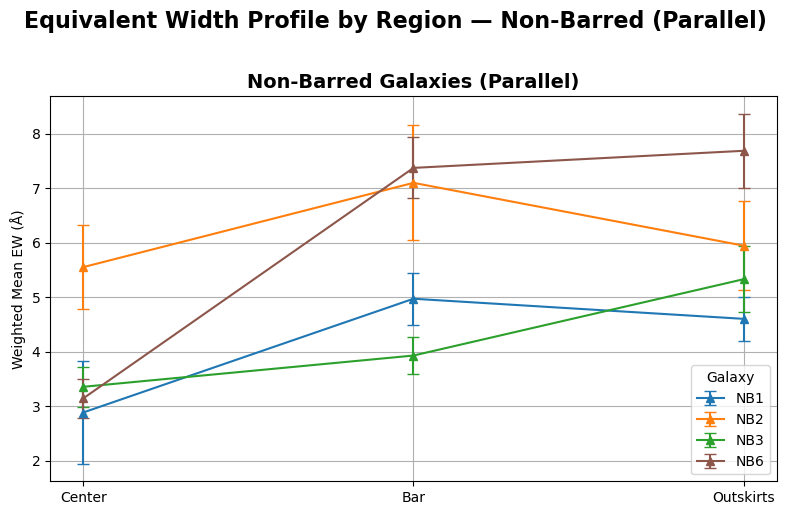

In [26]:
x_labels = ["Center", "Bar", "Outskirts"]
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(8, 5))

# --- Parallel only ---
for _, row in summary_parallel.iterrows():
    nb_id = int(row["WB"])
    vals  = [row["EW_center"], row["EW_bar"], row["EW_out"]]
    errs  = [row["EW_center_err"], row["EW_bar_err"], row["EW_out_err"]]
    ax.errorbar(x_pos, vals, yerr=errs, marker='^', capsize=4,
                label=f"NB{nb_id}", color=color_map[nb_id])

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Weighted Mean EW (Å)")
ax.set_title("Non-Barred Galaxies (Parallel)", fontsize=14, fontweight="bold")
ax.grid(True)
ax.legend(title="Galaxy")

# --- Big title ---
fig.suptitle("Equivalent Width Profile by Region — Non-Barred (Parallel)", 
             fontsize=16, fontweight="bold", y=1.02)

plt.tight_layout()
plt.show()


In [15]:
center_pixels = {
    1: 194,
    2: 189,
    3: 191,
    4: 190,
    5: 191,
    6: 196,
    7: 199,}

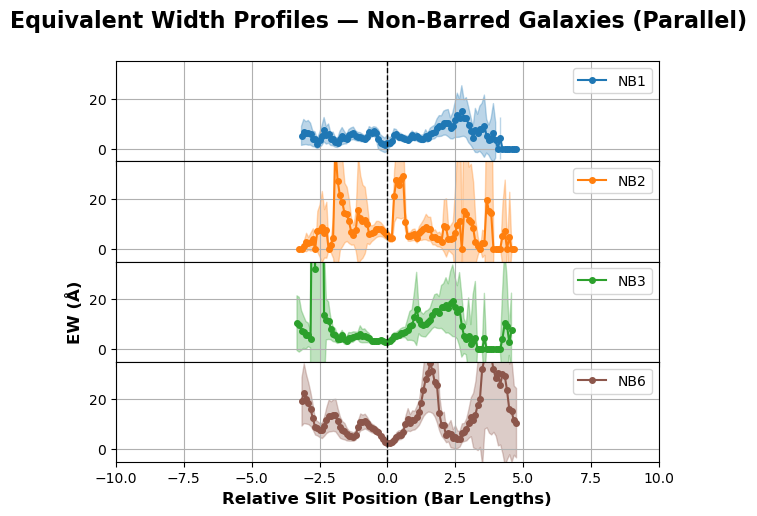

In [28]:
# --- EW for NB (parallel only) ---
fig, axs = plt.subplots(len(dfs_parallel), 1, figsize=(7, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

# Ensure axs is always iterable
if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / nb_bar_lengths[i]  # using median bar length for NB

    axs[row_idx].plot(x_scaled_p, df_p["EW"], "o-", color=color_map[i], label=f"NB{i}", ms=4)
    axs[row_idx].fill_between(
        x_scaled_p,
        df_p["EW"] - df_p["EW_err"],
        df_p["EW"] + df_p["EW_err"],
        color=color_map[i], alpha=0.3
    )
    axs[row_idx].set_ylim(-5, 35)
    axs[row_idx].set_xlim(-10, 10)
    axs[row_idx].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx].grid(True)
    axs[row_idx].legend(loc="upper right", fontsize=10)

# Labels
axs[-1].set_xlabel("Relative Slit Position (Bar Lengths)", fontsize=12, fontweight="bold")
axs[len(dfs_parallel)//2].set_ylabel("EW (Å)", fontsize=12, fontweight="bold")

plt.suptitle("Equivalent Width Profiles — Non-Barred Galaxies (Parallel)", fontsize=16, fontweight="bold")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()


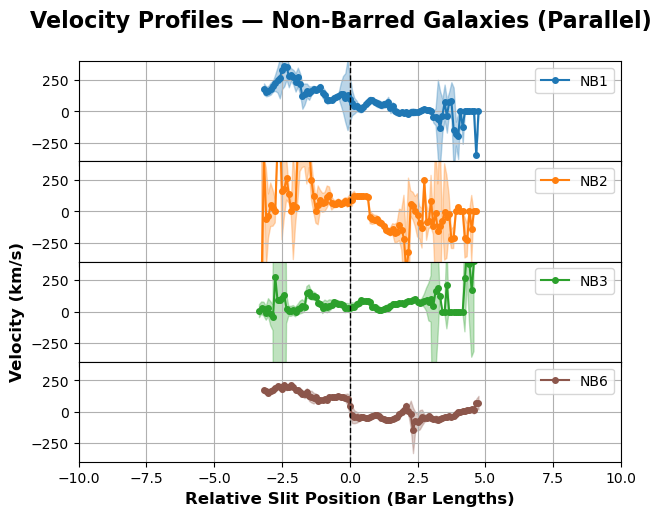

In [30]:
# --- Velocity for NB (parallel only) ---
fig, axs = plt.subplots(len(dfs_parallel), 1, figsize=(7, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / nb_bar_lengths[i]

    axs[row_idx].plot(x_scaled_p, df_p["velocity"], "o-", color=color_map[i], label=f"NB{i}", ms=4)
    axs[row_idx].fill_between(
        x_scaled_p,
        df_p["velocity"] - df_p["velocity_err"],
        df_p["velocity"] + df_p["velocity_err"],
        color=color_map[i], alpha=0.3
    )
    axs[row_idx].set_ylim(-400, 400)
    axs[row_idx].set_xlim(-10, 10)
    axs[row_idx].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx].grid(True)
    axs[row_idx].legend(loc="upper right", fontsize=10)

axs[-1].set_xlabel("Relative Slit Position (Bar Lengths)", fontsize=12, fontweight="bold")
axs[len(dfs_parallel)//2].set_ylabel("Velocity (km/s)", fontsize=12, fontweight="bold")

plt.suptitle("Velocity Profiles — Non-Barred Galaxies (Parallel)", fontsize=16, fontweight="bold")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()


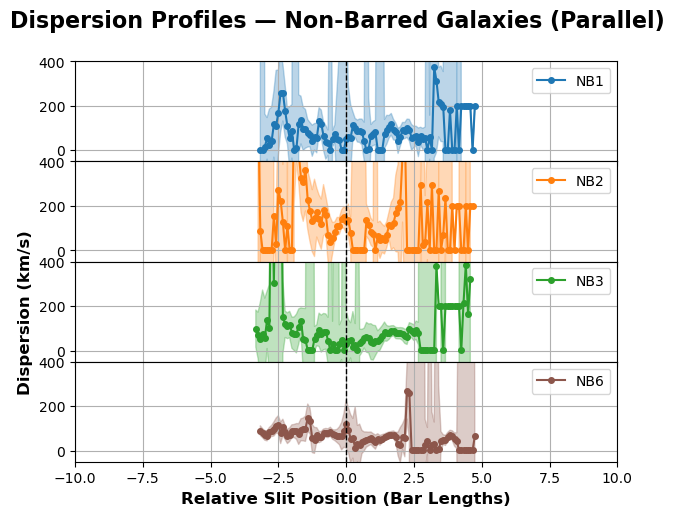

In [29]:
# --- Dispersion for NB (parallel only) ---
fig, axs = plt.subplots(len(dfs_parallel), 1, figsize=(7, 1.3*len(dfs_parallel)), sharex=True, sharey=True)

if len(dfs_parallel) == 1:
    axs = [axs]

for row_idx, i in enumerate(dfs_parallel.keys()):
    df_p = dfs_parallel[i]
    x_rel_p = (df_p["center"] - center_pixels[i]) * 0.4
    x_scaled_p = x_rel_p / nb_bar_lengths[i]

    axs[row_idx].plot(x_scaled_p, df_p["dispersion"], "o-", color=color_map[i], label=f"NB{i}", ms=4)
    axs[row_idx].fill_between(
        x_scaled_p,
        df_p["dispersion"] - df_p["dispersion_err"],
        df_p["dispersion"] + df_p["dispersion_err"],
        color=color_map[i], alpha=0.3
    )
    axs[row_idx].set_ylim(-50, 400)
    axs[row_idx].set_xlim(-10, 10)
    axs[row_idx].axvline(0, color="black", ls="--", lw=1)
    axs[row_idx].grid(True)
    axs[row_idx].legend(loc="upper right", fontsize=10)

axs[-1].set_xlabel("Relative Slit Position (Bar Lengths)", fontsize=12, fontweight="bold")
axs[len(dfs_parallel)//2].set_ylabel("Dispersion (km/s)", fontsize=12, fontweight="bold")

plt.suptitle("Dispersion Profiles — Non-Barred Galaxies (Parallel)", fontsize=16, fontweight="bold")
plt.subplots_adjust(hspace=0, wspace=0.05)
plt.show()
